# 第二问预测

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.svm import SVC
from sklearn import metrics

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score,precision_score,recall_score

In [154]:
#  Voting
data = pd.read_csv('./excel/extract/1/第一问特征提取.csv',
                   encoding='utf-8',
                   index_col='企业代号')
for i in range(len(data)):
    a = 'E' + str(i + 1)
    # One-hot
    if data.loc[a, '是否违约'] == '否':
        data.loc[a, '违约'] = 0
    else:
        data.loc[a, '违约'] = 1

x = data.iloc[:, 1:-3].values
y = data.iloc[:, -1].values
print(x.shape)

(123, 20)


In [155]:
# init model

lgb = LGBMClassifier(learning_rate=0.05,
                     n_estimators=100,
                     objective='binary',
                     boosting_type='gbdt',
                     num_leaves=2**5,
                     max_depth=5,
                     reg_alpha=0.5,
                     reg_lambda=0.5,
                     metric='auc',
                     subsample=0.75)
LR = LogisticRegression(C=0.1,
                        class_weight=None,
                        dual=False,
                        fit_intercept=True,
                        intercept_scaling=1,
                        l1_ratio=None,
                        max_iter=100,
                        multi_class='auto',
                        n_jobs=None,
                        penalty='l2',
                        random_state=None,
                        solver='newton-cg',
                        tol=0.0001,
                        verbose=0,
                        warm_start=False)
Ada = ada(algorithm='SAMME',
          base_estimator=None,
          learning_rate=0.1,
          n_estimators=100,
          random_state=30)
GBDT = GradientBoostingClassifier(ccp_alpha=0.0,
                                  criterion='friedman_mse',
                                  init=None,
                                  learning_rate=0.7,
                                  loss='exponential',
                                  max_depth=3,
                                  max_features='auto',
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  n_estimators=25,
                                  n_iter_no_change=None,
                                  random_state=30,
                                  subsample=1.0,
                                  tol=0.0001,
                                  validation_fraction=0.1,
                                  verbose=0,
                                  warm_start=False)
svc = SVC(C=0.8,
          break_ties=False,
          cache_size=200,
          class_weight=None,
          coef0=0.0,
          decision_function_shape='ovr',
          degree=3,
          gamma=20,
          kernel='rbf',
          max_iter=-1,
          probability=True,
          random_state=None,
          shrinking=True,
          tol=0.001,
          verbose=False)

rf = RF(bootstrap=True,
        ccp_alpha=0.0,
        class_weight=None,
        criterion='gini',
        max_depth=None,
        max_features='auto',
        max_leaf_nodes=None,
        max_samples=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=1,
        min_samples_split=2,
        min_weight_fraction_leaf=0.0,
        n_estimators=100,
        n_jobs=None,
        oob_score=False,
        random_state=30,
        verbose=0,
        warm_start=False)

sclf = StackingCVClassifier(classifiers=[Ada, GBDT, LR, rf],
                            use_probas=True,
                            meta_classifier=svc,
                            random_state=30)


In [156]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=30)

# (x - u) / s  归一化
tranfer = StandardScaler()
print(x_train.shape)
x = tranfer.fit_transform(x)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)

metric_xlsx = {}
weight = []
for clf, label in zip(
    [LR, Ada, GBDT, svc, rf, sclf, lgb],
    ['LR', 'Ada', 'GBDT', 'svc', 'rf', 'StackingClassifier', 'LGBMClassifier'
     ]):
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)

    tem_1 = [
        recall_score(y_test, y_predict),
        precision_score(y_test, y_predict),
        metrics.f1_score(y_test, y_predict),
        metrics.accuracy_score(y_test, y_predict),
        metrics.accuracy_score(y_train, clf.predict(x_train)),
        metrics.roc_auc_score(y_test,
                              clf.predict_proba(x_test)[:, 1])
    ]

    metric_xlsx[label] = tem_1
    tem = metrics.accuracy_score(y, clf.predict(x))
    weight.append(tem)
    # print('{}在预测集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_test, y_predict))
    # print('{}在训练集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_train, clf.predict(x_train)))
    # print('{}的综合准确率为：\n'.format(label), metrics.accuracy_score(y, clf.predict(x)))
    # print('{}的ROC面积为：'.format(label), metrics.roc_auc_score(y, clf.predict(x)))
    # print('---'*8)


(92, 20)


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=0.1, solver='newton-cg')),
                             ('Ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=0.1,
                                                 n_estimators=100,
                                                 random_state=30)),
                             ('GBDT',
                              GradientBoostingClassifier(learning_rate=0.7,
                                                         loss='exponential',
                                                         max_features='auto',
                                                         n_estimators=25,
                                                         random_state=30)),
                             ('SVC', SVC(C=0.8, gamma=20, probability=True)),
                             (...
                                               

In [ ]:
data2 = pd.DataFrame(data=metric_xlsx,
                     index=[
                         'train_Accuracy', 'test_Accuracy', 'Precision',
                         'Recall', 'AUC', 'f1'
                     ]).T
data2
vote2 = VotingClassifier(estimators=[('LR', LR), ('Ada', Ada), ('GBDT', GBDT),
                                     ('SVC', svc), ('rf', rf),
                                     ('StackingClassifier', sclf),
                                     ('LGBMClassifier', lgb)],
                         voting='soft',
                         weights=weight)
vote2.fit(x_train, y_train)
vote2.fit(x_test, y_test)

In [164]:
# new_da = pd.read_csv('./excel/extract/1/第一问特征提取.csv', encoding='utf-8')
new_da = pd.read_csv('./excel/extract/2/第二问特征提取.csv', encoding='utf-8')
new_da.head(3)

,企业代号,销-进金额,增值税,持续一年期的交易企业个数,持续二年期的交易企业个数,持续三年期的交易企业个数,持续四年前的交易企业个数,持续一年期的交易企业个数.1,持续二年期的交易企业个数.1,持续三年期的交易企业个数.1,...,进项发票的作废比例,销项发票的作废比例,绝对数变化,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营
0,E124,-3.646980e+07,0.00,919,352,132,0,22,18,12,...,0.123313,0.150039,-4.578985e+07,-0.902160,0,1,0,0,0,1
1,E125,1.947530e+06,15344245.88,1213,417,159,0,28,26,9,...,0.123817,0.134796,-8.292186e+07,-0.278589,0,1,0,0,0,1
2,E126,5.115072e+08,4795532.77,50,17,5,0,96,34,13,...,0.033771,0.166227,1.170456e+08,2.482219,0,0,0,0,0,1


In [165]:
new_x = new_da.iloc[:,1:].values
print(new_x.shape)
tranfer = StandardScaler()
new_x = tranfer.fit_transform(new_x)

(301, 20)


In [166]:
wieyue = vote2.predict(new_x)
sigma = vote2.predict_proba(new_x)[:, 1]
new_da['是否违约']=wieyue
new_da['违约风险']=sigma
print(wieyue)
new_da.to_csv('./excel/result/2/已经判断是否违约.csv', encoding='gbk')
new_da.head()

[1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


,企业代号,销-进金额,增值税,持续一年期的交易企业个数,持续二年期的交易企业个数,持续三年期的交易企业个数,持续四年前的交易企业个数,持续一年期的交易企业个数.1,持续二年期的交易企业个数.1,持续三年期的交易企业个数.1,...,绝对数变化,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,是否违约,违约风险
0,E124,-3.646980e+07,0.00,919,352,132,0,22,18,12,...,-4.578985e+07,-0.902160,0,1,0,0,0,1,1.0,0.507123
1,E125,1.947530e+06,15344245.88,1213,417,159,0,28,26,9,...,-8.292186e+07,-0.278589,0,1,0,0,0,1,0.0,0.494483
2,E126,5.115072e+08,4795532.77,50,17,5,0,96,34,13,...,1.170456e+08,2.482219,0,0,0,0,0,1,1.0,0.530259
3,E127,6.950971e+08,20794844.85,229,50,17,0,12,7,6,...,-8.236123e+07,0.662969,0,0,0,0,0,1,1.0,0.501052
4,E128,2.453806e+08,8473701.96,404,101,25,0,4,2,1,...,8.099251e+07,2.935291,0,0,0,0,0,1,1.0,0.517707


#  第二问循环预测

In [187]:
data = pd.read_csv('./excel/extract/1/第一问特征提取.csv',
                   encoding='utf-8')
data.head()

,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,评级,信誉评级,是否违约
0,E1,-1.898184e+09,0.000000e+00,179,51,51,71,332,74,27,...,1.720614,0,0,0,0,1,0,0,A,0
1,E2,4.262976e+08,2.826162e+07,1147,268,121,43,2424,780,314,...,2.197674,0,0,0,0,1,0,0,A,0
2,E3,5.149872e+08,8.856227e+07,48,48,25,14,386,103,58,...,0.516353,0,0,0,1,0,0,2,C,0
3,E4,1.511803e+09,2.543300e+08,16,10,0,0,94,21,13,...,0.053642,0,0,0,0,1,0,2,C,0
4,E5,6.915274e+05,5.489589e+05,16,15,2,0,324,47,19,...,85.227087,0,0,0,0,1,0,1,B,0


In [188]:

y = data['评级'].values  # 评价等级编码
x = data.drop(['企业代号','信誉评级','评级'],axis=1).values

print(x.shape)
print(y.shape)
data

(123, 21)
(123,)


,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,评级,信誉评级,是否违约
0,E1,-1.898184e+09,0.000000e+00,179,51,51,71,332,74,27,...,1.720614,0,0,0,0,1,0,0,A,0
1,E2,4.262976e+08,2.826162e+07,1147,268,121,43,2424,780,314,...,2.197674,0,0,0,0,1,0,0,A,0
2,E3,5.149872e+08,8.856227e+07,48,48,25,14,386,103,58,...,0.516353,0,0,0,1,0,0,2,C,0
3,E4,1.511803e+09,2.543300e+08,16,10,0,0,94,21,13,...,0.053642,0,0,0,0,1,0,2,C,0
4,E5,6.915274e+05,5.489589e+05,16,15,2,0,324,47,19,...,85.227087,0,0,0,0,1,0,1,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E119,-1.841203e+05,0.000000e+00,12,1,1,0,7,6,2,...,6.999117,0,0,0,0,1,0,3,D,1
119,E120,1.624161e+05,3.780940e+03,6,0,0,0,13,3,0,...,1.139033,0,0,0,0,1,0,3,D,1
120,E121,-9.720242e+05,0.000000e+00,110,6,0,0,7,2,2,...,-0.075122,1,0,0,0,1,0,3,D,1
121,E122,7.342160e+03,0.000000e+00,67,2,0,0,18,3,1,...,-0.681496,0,1,0,0,1,0,3,D,1


In [200]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=30)

# tranfer = StandardScaler()
# x = tranfer.fit_transform(x)
from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(x_train)
x = tranfer.fit_transform(x)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)
print(y_train)

[2 2 1 0 1 3 3 2 2 3 2 2 1 1 1 2 1 0 2 2 3 3 3 3 2 1 2 2 1 0 2 1 3 0 1 0 2
 0 2 1 1 3 0 0 1 2 1 3 3 1 1 1 1 0 2 2 1 1 2 3 0 1 3 1 3 3 1 1 0 0 2 2 0 3
 1 3 2 1 0 0 2 2 0 0 2 0 0 3 3 2 3 1]


# XGB调参

In [201]:
other_params = {'learning_rate': 0.16, 'max_depth': 6, 'min_child_weight': 2, 'seed': 10,'estimator':60,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.08, 'reg_lambda': 0.12}
from xgboost import XGBClassifier
estimator = XGBClassifier(objective='multi:softmax',num_class=4,eval_metric='auc',**other_params)

# 加入网格搜索和叫交叉验证
param_dict = {'learning_rate': [i*0.01 for i in range(16,31)]}

estimator = GridSearchCV(estimator,param_grid=param_dict,cv=5,scoring='accuracy')
estimator.fit(x_train,y_train)
# print('最好分数:',estimator.best_score_)
# print('最佳预估器:',estimator.best_params_)
# print('最佳参数：',estimator.best_estimator_)

y_predict = estimator.predict(x_test)
print('预测集模型的准确率为：\n', metrics.accuracy_score(y_test, y_predict))
print('训练集模型的准确率为：\n',
      metrics.accuracy_score(y_train, estimator.predict(x_train)))
print('综合准确率为：\n', metrics.accuracy_score(y, estimator.predict(x)))


[00:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "estimator" } might not be used.

  This could b

In [204]:
# new = pd.read_csv('已经判断是否违约.csv',encoding='gbk')
new = pd.read_csv('./excel/result/2/已经判断是否违约.csv', encoding='gbk')
# new.head()
new_x = new.iloc[:,2:-1].values
new_x = tranfer.transform(new_x)
predict_y = estimator.predict(new_x)
print(predict_y)
new['信誉评级'] = predict_y
new.to_csv('./excel/result/2/第二问最终分类结果.csv',encoding='gbk')
new.head()

[3 2 3 3 0 2 0 2 3 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 3 1 2 3 2 1 2 0
 1 0 0 3 0 0 0 2 1 0 0 1 2 1 0 0 0 1 0 0 0 1 0 0 1 0 3 0 1 1 1 0 2 0 0 0 0
 0 0 3 1 2 0 0 2 0 2 3 0 0 3 0 0 1 0 0 3 2 2 0 1 0 2 1 0 1 0 0 0 1 0 2 1 0
 3 3 3 2 3 3 3 3 0 3 1 0 1 0 2 0 1 0 0 2 3 2 2 0 2 0 0 1 1 3 1 1 2 1 0 3 0
 3 2 2 2 0 2 1 1 2 0 2 1 0 3 1 0 3 0 0 0 1 2 3 0 1 2 2 1 0 0 0 0 1 2 3 1 1
 3 1 0 1 0 0 0 3 1 2 2 2 1 1 2 0 1 0 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 0 2 2 1
 3 1 2 2 1 1 1 2 1 2 2 2 2 2 2 2 2 1 1 0 2 2 2 2 2 2 2 3 2 2 2 1 1 2 2 0 2
 2 3 2 3 2 2 2 2 2 1 2 0 1 1 2 2 2 2 1 2 2 3 2 2 2 1 2 2 1 2 1 2 2 2 1 2 1
 1 2 2 2 2]


,Unnamed: 0,企业代号,销-进金额,增值税,持续一年期的交易企业个数,持续二年期的交易企业个数,持续三年期的交易企业个数,持续四年前的交易企业个数,持续一年期的交易企业个数.1,持续二年期的交易企业个数.1,...,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,是否违约,违约风险,信誉评级
0,0,E124,-3.646980e+07,0.00,919,352,132,0,22,18,...,-0.902160,0,1,0,0,0,1,1.0,0.507123,3
1,1,E125,1.947530e+06,15344245.88,1213,417,159,0,28,26,...,-0.278589,0,1,0,0,0,1,0.0,0.494483,2
2,2,E126,5.115072e+08,4795532.77,50,17,5,0,96,34,...,2.482219,0,0,0,0,0,1,1.0,0.530259,3
3,3,E127,6.950971e+08,20794844.85,229,50,17,0,12,7,...,0.662969,0,0,0,0,0,1,1.0,0.501052,3
4,4,E128,2.453806e+08,8473701.96,404,101,25,0,4,2,...,2.935291,0,0,0,0,0,1,1.0,0.517707,0


In [ ]:
input1 = pd.read_excel('.\excel\附件2：302家无信贷记录企业的相关数据.xlsx',
                       sheet_name='销项发票信息')
output1 = pd.read_excel('.\excel\附件2：302家无信贷记录企业的相关数据.xlsx',sheet_name='进项发票信息')

In [ ]:
in_20 = input1[input1['开票日期']>'2020']
out_20 = output1[output1['开票日期']>'2020']

In [ ]:
in_19 = input1[(input1['开票日期']>'2019') & (input1['开票日期']<'2020')]
out_19 = output1[(output1['开票日期']>'2019') & (output1['开票日期']<'2020')]

In [ ]:
C_i_20 = in_20['企业代号'].unique()       # 本身企业的数量
C_o_20 = out_20['企业代号'].unique()
C_i_19 = in_19['企业代号'].unique()
C_o_19 = out_19['企业代号'].unique()
all1 = new['企业代号'].values

In [ ]:
jin_2020=[]          
for i in range(len(all1)):
    if all1[i] in C_i_20:
        tem = len(in_20[in_20['企业代号']==all1[i]]['购方单位代号'].unique())
    else:
        tem = 0
    
    jin_2020.append(tem)
    
    
jin_2019=[]          
for i in range(len(all1)):
    if all1[i] in C_i_19:
        tem = len(in_19[in_19['企业代号']==all1[i]]['购方单位代号'].unique())
    else:
        tem = 0
    
    jin_2019.append(tem)

    
xiao_2020=[]
for i in range(len(all1)):
    if all1[i] in C_o_20:
        tem = len(out_20[out_20['企业代号']==all1[i]]['销方单位代号'].unique())
    else:
        tem = 0
    
    xiao_2020.append(tem)
    
xiao_2019=[]
for i in range(len(all1)):
    if all1[i] in C_o_19:
        tem = len(out_19[out_19['企业代号']==all1[i]]['销方单位代号'].unique())
    else:
        tem = 0
    
    xiao_2019.append(tem)

In [ ]:
da2 = {'2020年进项交易企业数':jin_2020,
      '2020年销项交易企业数':xiao_2020,
      '2019年进项交易企业数':jin_2019,
      '2019年销项交易企业数':xiao_2019}
data2 = pd.DataFrame(data=da2)
data2

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数
0,0,0,32,815
1,0,0,46,1127
2,0,0,96,42
3,0,0,18,159
4,0,0,2,290
...,...,...,...,...
297,0,0,1,3
298,1,0,11,2
299,0,0,1,4
300,0,0,8,7


In [ ]:
data2['进项交易企业变化率'] = data2['2020年进项交易企业数']-data2['2019年进项交易企业数']/data2['2019年进项交易企业数']
data2['销项交易企业变化率'] = data2['2020年销项交易企业数']-data2['2019年销项交易企业数']/data2['2019年销项交易企业数']
data2.loc[205,'销项交易企业变化率'] = 1
data2.loc[225,'进项交易企业变化率'] = 0
data2.loc[258,'销项交易企业变化率'] = 0
data2

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数,进项交易企业变化率,销项交易企业变化率
0,0,0,32,815,-1.0,-1.0
1,0,0,46,1127,-1.0,-1.0
2,0,0,96,42,-1.0,-1.0
3,0,0,18,159,-1.0,-1.0
4,0,0,2,290,-1.0,-1.0
...,...,...,...,...,...,...
297,0,0,1,3,-1.0,-1.0
298,1,0,11,2,0.0,-1.0
299,0,0,1,4,-1.0,-1.0
300,0,0,8,7,-1.0,-1.0


In [ ]:
data2[data2.isnull().values==True]

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数,进项交易企业变化率,销项交易企业变化率


In [ ]:
data2.to_csv('第三问交易企业变化率.csv',encoding='gbk')

#  聚类结果后特征描述性统计分析

In [ ]:
data3 = pd.read_excel('第三问所有聚类特征与结果.xlsx',encoding='gbk')
data3

,企业代号,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
0,E124,1,-1.000000,0.123313,0.150039,-1,-1,-0.330,1,2
1,E125,1,-1.000000,0.123817,0.134796,-1,-1,-0.330,1,2
2,E126,1,-1.000000,0.033771,0.166227,-1,-1,-0.330,1,1
3,E127,1,-1.000000,0.017931,0.030303,-1,-1,-0.330,1,2
4,E128,1,-1.000000,0.027312,0.074900,-1,-1,-0.330,1,2
...,...,...,...,...,...,...,...,...,...,...
297,E421,-1,1.000000,0.000000,0.034483,-1,-1,-0.102,2,3
298,E422,1,-0.022104,0.000000,0.100000,0,-1,-0.102,1,3
299,E423,0,0.000000,0.000000,0.142857,-1,-1,-0.102,2,4
300,E424,-1,1.000000,0.000000,0.139535,-1,-1,-0.101,2,4


In [ ]:
A = data3[data3['聚类类别']==1]
B = data3[data3['聚类类别']==2]
C = data3[data3['聚类类别']==3]

In [ ]:
A.describe().loc[['count','mean','min','max']].to_csv('类别1描述.csv',encoding='gbk')
B.describe().loc[['count','mean','min','max']].to_csv('类别2描述.csv',encoding='gbk')
C.describe().loc[['count','mean','min','max']].to_csv('类别3描述.csv',encoding='gbk')

In [ ]:
A.describe().loc[['count','mean','min','max']]

,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.00000,239.0,239.000000
mean,0.995816,-1.539096,0.031033,0.115455,3.987448,7.129707,-0.12028,1.0,2.267782
min,0.000000,-159.795134,0.000000,0.000000,-1.000000,-1.000000,-0.33000,1.0,1.000000
max,1.000000,33.786811,0.250000,0.838710,116.000000,101.000000,0.12600,1.0,4.000000


In [ ]:
min(A['同比增长速度'])

-159.7951336

In [ ]:
A

,企业代号,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
0,E124,1,-1.000000,0.123313,0.150039,-1,-1,-0.330,1,2
1,E125,1,-1.000000,0.123817,0.134796,-1,-1,-0.330,1,2
2,E126,1,-1.000000,0.033771,0.166227,-1,-1,-0.330,1,1
3,E127,1,-1.000000,0.017931,0.030303,-1,-1,-0.330,1,2
4,E128,1,-1.000000,0.027312,0.074900,-1,-1,-0.330,1,2
...,...,...,...,...,...,...,...,...,...,...
287,E411,1,-1.083556,0.000000,0.309278,-1,0,-0.102,1,4
288,E412,1,-0.929089,0.034884,0.080537,0,0,-0.101,1,3
289,E413,1,-23.381118,0.000000,0.175000,1,0,-0.102,1,3
290,E414,1,-1.000000,0.000000,0.214286,-1,-1,-0.101,1,3


# 画图

In [ ]:
data4 = pd.read_excel('第三问所有聚类特征与结果.xlsx',encoding='gbk',sheet_name='Sheet1')
data4 = data4.iloc[0:34,:]

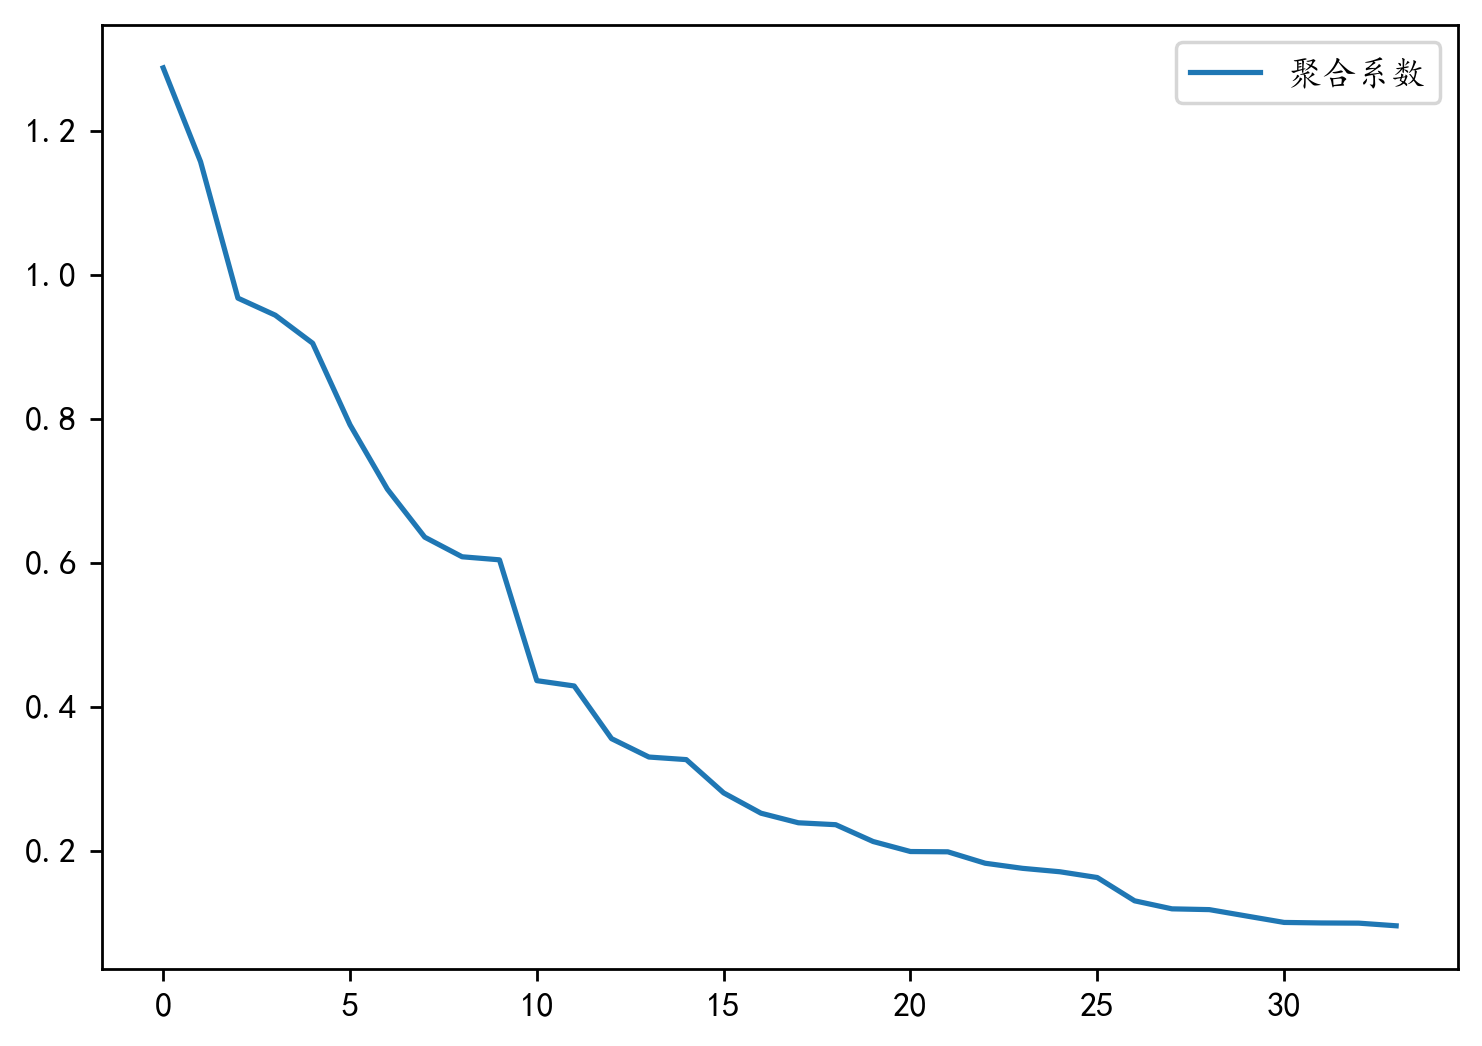

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.figure(figsize=(7,5),dpi=250)
plt.plot(data4.values,label='聚合系数')
plt.legend()
plt.show()

In [ ]:
ddd = pd.read_csv('第二问最终分类结果.csv',encoding='gbk')
ddd

,企业代号,是否违约,信誉评级
0,E124,0,2
1,E125,0,2
2,E126,0,1
3,E127,0,2
4,E128,0,2
...,...,...,...
297,E421,0,3
298,E422,0,3
299,E423,1,4
300,E424,1,4


In [ ]:
for i in range(len(ddd)):
    if ddd.loc[i,'信誉评级']==1:
        ddd.loc[i,'评级']='A'
    elif ddd.loc[i,'信誉评级']==2:
        ddd.loc[i,'评级']='B'
    elif ddd.loc[i,'信誉评级']==3:
        ddd.loc[i,'评级']='C'
    elif ddd.loc[i,'信誉评级']==4:
        ddd.loc[i,'评级']='D'

In [ ]:
ddd.to_csv('有评级.csv',encoding='gbk')